# 고객의 앱 분석을 통한 구독 유도하기

무료에서 유료로 전환되는 유튜브 프리미엄과 같은 부가 서비스를 구독할 수 있는 제품들이 있다.


무료 구독자들 중 잠재적인 유료 구독자들과 생각이 없는 구독자들을 판별하여 후자에게 더 홍보를 할 수 있도록 예측한다.


데이터 열:
1. 유저 번호
2. 가입날짜
3. 숫자 형식으로 요일
4. 앱을 처음 연 시간
5. 유저가 처음 24시간 동안 방문한 모든 화면
6. 5번의 개수
7. 미니게임 실행 여부
    - 1: 실행
    - 0: 안함
8. 유료 버전 사용 여부
    - 1: 실행
    - 0: 안함
9. 유료 버전 구독 여부
    - 1: 실행
    - 0: 안함
10. 구독 날짜
11. 좋아요 여부
    - 1: 실행
    - 0: 안함


출처:https://www.kaggle.com/code/kerneler/starter-appdata10-b5b7bbfe-1/data

# 목차

1. 데이터 읽기
2. 데이터 시각화
    - 히스토그램
    - 상관계수 그래프
3. 데이터 전처리
4. 모델 구축(혼동행렬, 분류성능평가지표)
    - 로지스틱회귀
    - K-겹 교차검증
5. 결론

# 데이터 읽기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import time
from dateutil import parser

In [2]:
data = pd.read_csv('appdata10.csv')
data.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


In [3]:
# 수치형 데이터로 만들어주기
data["hour"] = data.hour.str.slice(1, 3).astype(int)

In [4]:
# 쓸모없는 데이터들을 제외한다. enrolled는 반응변수
data2 = data.copy().drop(columns = ['user', 'screen_list', 'enrolled_date', 'first_open', 'enrolled'])
data2.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2,23,15,0,0,0
1,6,1,24,13,0,0,0
2,1,19,23,3,0,1,1
3,4,16,28,40,0,0,0
4,1,18,31,32,0,0,1


# 데이터 시각화

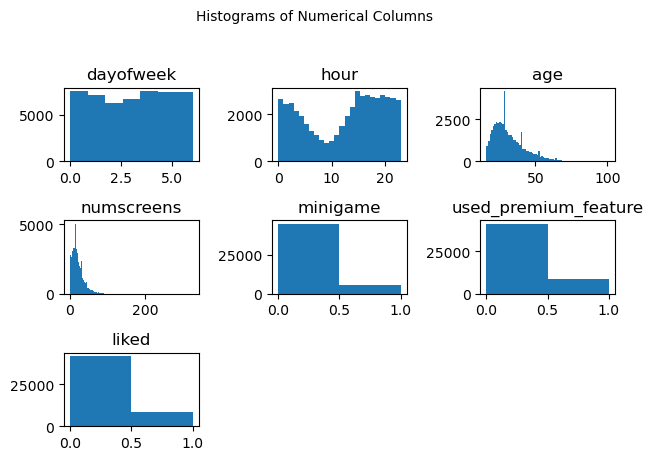

In [5]:
# 데이터 세트의 분포를 빠르게 알아보기 위해 히스토그램을 사용해 본다.
plt.suptitle('Histograms of Numerical Columns', fontsize=10)
for i in range(1, data2.shape[1] + 1):
    plt.subplot(3, 3, i)
    f = plt.gca()
    f.set_title(data2.columns.values[i - 1])
    vals = np.size(data2.iloc[:, i - 1].unique())
    plt.hist(data2.iloc[:, i - 1], bins=vals)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

<AxesSubplot:title={'center':'Correlation with Reposnse variable'}>

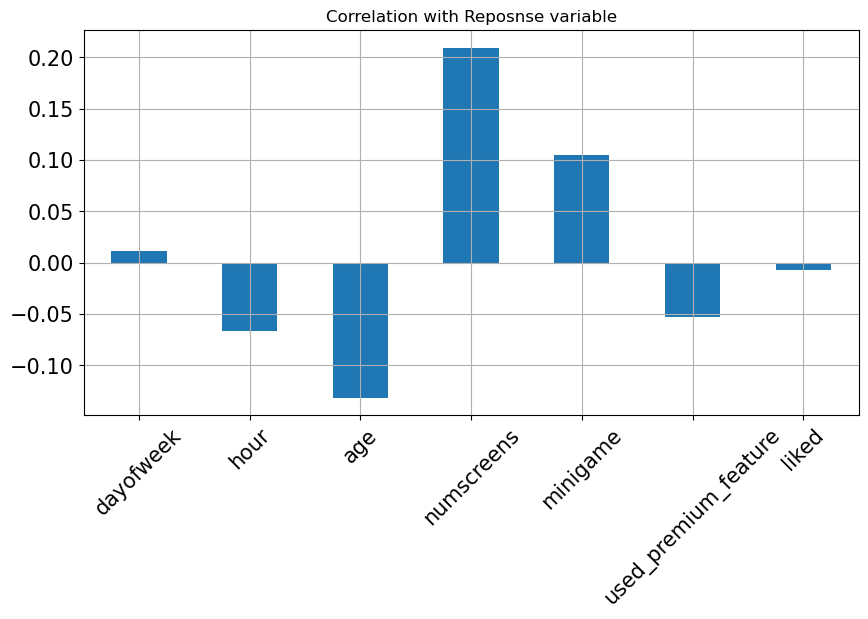

In [6]:
# 상관분석 그래프 만들기
data2.corrwith(data.enrolled).plot.bar(figsize=(10,5),
                  title = 'Correlation with Reposnse variable',
                  fontsize = 15, rot = 45,
                  grid = True)


C:\Users\user\anaconda3\envs\down\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


<AxesSubplot:>

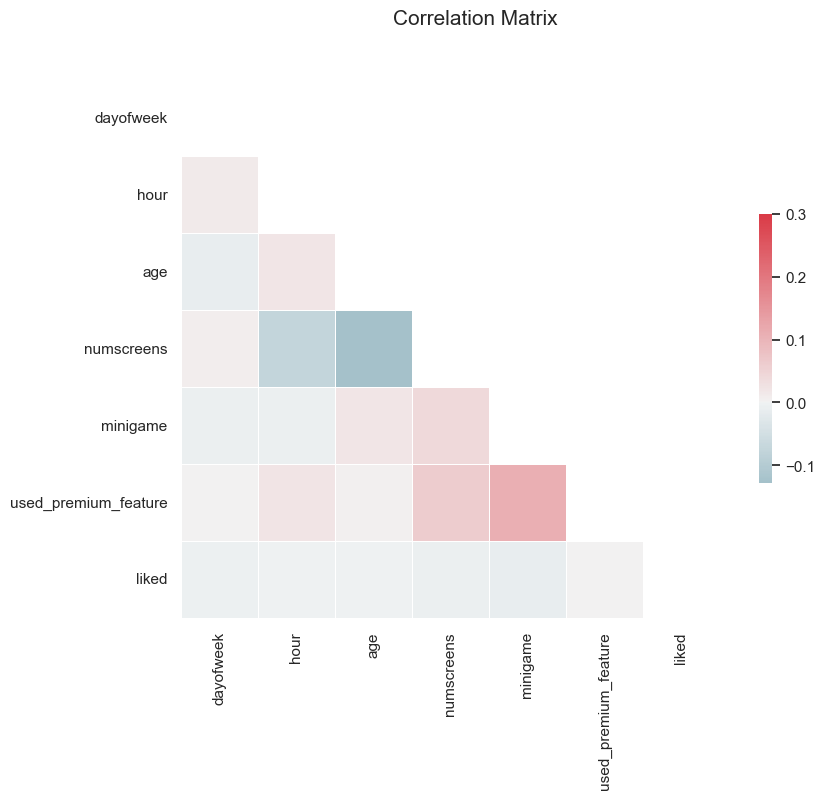

In [7]:
# 상관분석 행렬 
sn.set(style="white", font_scale=1)

# 2차원 배열로 완성
corr = data2.corr()

# 행렬을 반토막 낸다.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 7))
f.suptitle("Correlation Matrix", fontsize =15)

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#  변수 가공

앱을 설치한 후 무료 구독 서비스를 일주일까지만 제한하는 경우가 있다.


변수 가공을 함으로써 반응변수에 날짜 범위 제한을 해보자.

In [8]:
# 자료형 살펴보기
data.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                     int32
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

In [9]:
data["first_open"]

0        2012-12-27 02:14:51.273
1        2012-12-02 01:16:00.905
2        2013-03-19 19:19:09.157
3        2013-07-05 16:08:46.354
4        2013-02-26 18:50:48.661
                  ...           
49995    2013-05-09 13:46:17.871
49996    2013-04-09 00:05:17.823
49997    2013-02-20 22:41:51.165
49998    2013-04-28 12:33:04.288
49999    2012-12-14 01:22:44.638
Name: first_open, Length: 50000, dtype: object

In [10]:
# datetime 객체로 변환하기
data["first_open"] = [parser.parse(row_date) for row_date in data["first_open"]]
data["enrolled_date"] = [parser.parse(row_date) if isinstance(row_date, str) else row_date for row_date in data["enrolled_date"]]

In [11]:
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

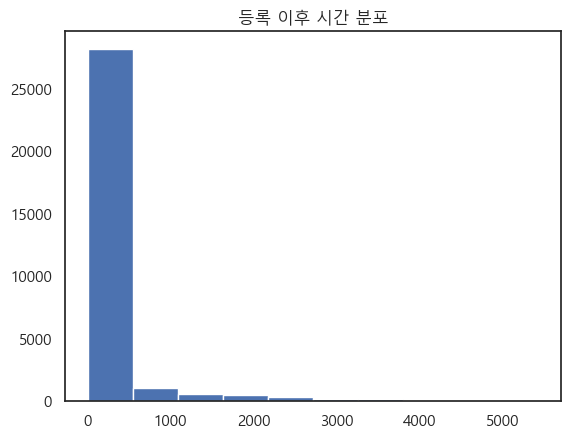

In [12]:
# 시간 단위로 나누기
data["difference"] = (data.enrolled_date - data.first_open).astype('timedelta64[h]')
response_hist = plt.hist(data["difference"].dropna())
plt.title('등록 이후 시간 분포')
plt.show()

0-500시간에 분포가 편향되어 있기 때문에 0~50시간으로 줄여본다.

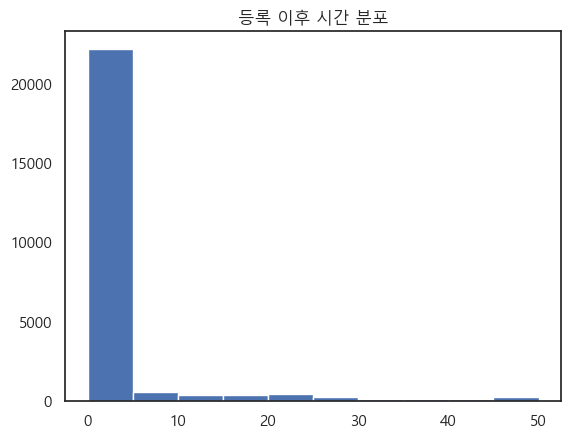

In [13]:
plt.hist(data["difference"].dropna(), range = [0, 50])
plt.title('등록 이후 시간 분포')
plt.show()

In [14]:
# 구독 기회를 최초 48시간까지 부여한다. 그 뒤는 0으로 만든다.

data.loc[data.difference > 48, 'enrolled'] = 0
data = data.drop(columns=['enrolled_date', 'difference', 'first_open'])

In [15]:
# 스크린 리스트에 변수 가공
# 사람들이 가장 많이 사용한 화면을 불러온다.
top_screens = pd.read_csv('top_screens.csv').top_screens.values
top_screens

array(['Loan2', 'location', 'Institutions', 'Credit3Container',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth',
       'ProfilePage', 'VerifyCountry', 'Cycle', 'idscreen',
       'Credit3Dashboard', 'Loan3', 'CC1Category', 'Splash', 'Loan',
       'CC1', 'RewardsContainer', 'Credit3', 'Credit1', 'EditProfile',
       'Credit2', 'Finances', 'CC3', 'Saving9', 'Saving1', 'Alerts',
       'Saving8', 'Saving10', 'Leaderboard', 'Saving4', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'Saving7', 'ProfileEducationMajor', 'Rewards', 'AccountView',
       'VerifyAnnualIncome', 'VerifyIncomeType', 'Saving2', 'Saving6',
       'Saving2Amount', 'Saving5', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'Loan4',
       'ResendToken', 'TransactionList', 'NetworkFailure', 'ListPicker'],
      dtype=object)

In [16]:
data["screen_list"] = data.screen_list.astype(str) + ','

for sc in top_screens:
    data[sc] = data.screen_list.str.contains(sc).astype(int)
    data['screen_list'] = data.screen_list.str.replace(sc+",", "")

data['Other'] = data.screen_list.str.count(",")
data = data.drop(columns=['screen_list'])


In [17]:
# 모델간 상관관계 제거하고 퍼널로 그룹화하기
savings_screens = ["Saving1",
                    "Saving2",
                    "Saving2Amount",
                    "Saving4",
                    "Saving5",
                    "Saving6",
                    "Saving7",
                    "Saving8",
                    "Saving9",
                    "Saving10"]
data["SavingCount"] = data[savings_screens].sum(axis=1)
data = data.drop(columns=savings_screens)

cm_screens = ["Credit1",
               "Credit2",
               "Credit3",
               "Credit3Container",
               "Credit3Dashboard"]
data["CMCount"] = data[cm_screens].sum(axis=1)
data = data.drop(columns=cm_screens)

cc_screens = ["CC1",
                "CC1Category",
                "CC3"]
data["CCCount"] = data[cc_screens].sum(axis=1)
data = data.drop(columns=cc_screens)

loan_screens = ["Loan",
               "Loan2",
               "Loan3",
               "Loan4"]
data["LoansCount"] = data[loan_screens].sum(axis=1)
data = data.drop(columns=loan_screens)

In [18]:
data.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,Other,SavingCount,CMCount,CCCount,LoansCount
0,235136,3,2,23,15,0,0,0,0,0,...,0,0,0,0,0,7,0,0,0,1
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,5,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,234192,4,16,28,40,0,0,1,0,1,...,0,0,0,0,0,6,0,3,0,1
4,51549,1,18,31,32,0,0,1,1,0,...,0,0,0,0,0,10,0,2,0,1


In [19]:
data2 = pd.read_csv("new_appdata10.csv")

In [20]:
data2.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


In [21]:
# 빈응변수 enrolled 삭제
response = data2["enrolled"]
data2 = data2.drop(columns="enrolled")

# 데이터 전처리

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, response, test_size = 0.2, random_state = 0)

In [26]:
# 유저를 저장 후 삭제
train_identity = X_train['user']
X_train = X_train.drop(columns = ['user'])
test_identity = X_test['user']
X_test = X_test.drop(columns = ['user'])

In [27]:
# 특성 선택
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

In [28]:
# 로지스틱 회귀
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, penalty = 'l1', solver='liblinear')
classifier.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=0, solver='liblinear')

In [31]:
# 테스트 세트 예측
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred) # 정확도
prec = precision_score(y_test, y_pred) # 정밀도
rec = recall_score(y_test, y_pred) # 재현율
f1 = f1_score(y_test, y_pred) # F1 score

results = pd.DataFrame([['Linear Regression (Lasso)', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
print(results)

                       Model  Accuracy  Precision    Recall  F1 Score
0  Linear Regression (Lasso)    0.8823   0.970172  0.836521  0.898403


Test Data Accuracy: 0.8823


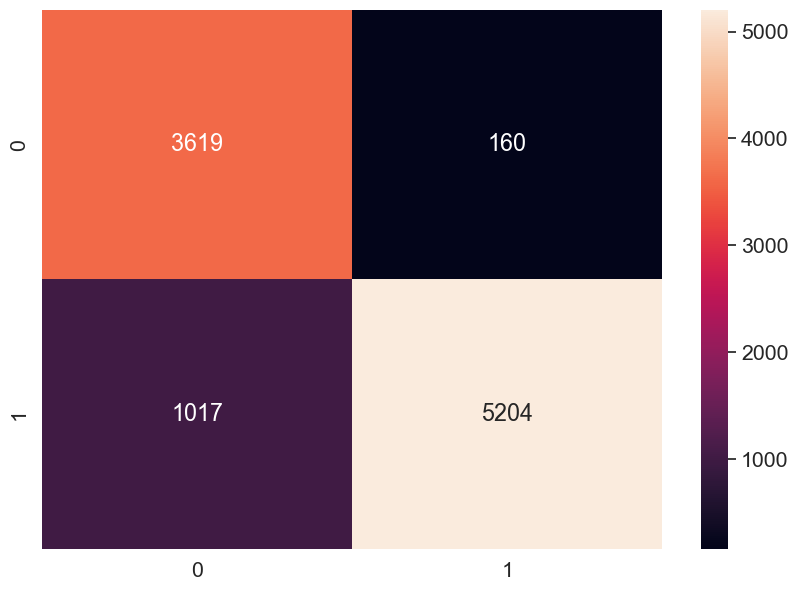

In [32]:
# 혼동 행렬
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

In [33]:
# k-겹 교차 검증
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

SVM Accuracy: 0.887 (+/- 0.010)


In [35]:
final_results = pd.concat([y_test, test_identity], axis = 1).dropna()
final_results['predicted_reach'] = y_pred
final_results = final_results[['user', 'enrolled', 'predicted_reach']].reset_index(drop=True)
print(final_results)

        user  enrolled  predicted_reach
0     239786         1                1
1     279644         1                1
2      98290         0                0
3     170150         1                1
4     237568         1                1
...      ...       ...              ...
9995  143036         1                1
9996   91158         1                1
9997  248318         0                0
9998  142418         1                1
9999  279355         1                1

[10000 rows x 3 columns]


# 결론

LASSO를 이용하여 88%의 정확도를 이끌어 낼 수 있었다.


K-겹 교차 검증에서 89%로 약 1%의 상승률을 보였다.


2가지 방법 뿐만 아니라, 랜덤 포레스트, SVM 등 다양한 평